# Flagship Cluster Catalogue Analysis

This notebook compares Euclid Flagship simulation cluster catalogue summary statistics with capish predictions.

In [1]:
import pyccl, sys
print("pyccl version:", pyccl.__version__)
print("pyccl path   :", pyccl.__file__)
print("python exe   :", sys.executable)

pyccl version: 3.2.1
pyccl path   : /sps/euclid/Users/cmurray/miniconda3/envs/capish/lib/python3.11/site-packages/pyccl/__init__.py
python exe   : /sps/euclid/Users/cmurray/miniconda3/envs/capish/bin/python


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

from modules.simulation import UniverseSimulator
import configparser

## 1. Load Flagship Summary Statistics

In [3]:
# Load Flagship data
flagship_path = project_root / 'euclid_flagship_simulations' / 'flagship_cluster_catalogue_summary_statstics_DES_MoR.npy'
flagship_data = np.load(flagship_path, allow_pickle=True).item()

print("Flagship data keys:", flagship_data.keys())
print("\nData shapes:")
for key, value in flagship_data.items():
    print(f"  {key}: {value.shape}")

Flagship data keys: dict_keys(['count_with_m200b_def', 'mean_log10m200b', 'count_with_m200c_def', 'mean_log10m200c'])

Data shapes:
  count_with_m200b_def: (5, 4)
  mean_log10m200b: (5, 4)
  count_with_m200c_def: (5, 4)
  mean_log10m200c: (5, 4)


In [4]:
# Extract data for easier access
flagship_counts_m200b = flagship_data['count_with_m200b_def']
flagship_mean_log10m200b = flagship_data['mean_log10m200b']
flagship_counts_m200c = flagship_data['count_with_m200c_def']
flagship_mean_log10m200c = flagship_data['mean_log10m200c']

# Define binning from config
richness_edges = np.array([20, 30, 50, 80, 130, 200])
redshift_edges = np.array([0.2, 0.3, 0.4, 0.8, 1.0])

n_richness_bins = len(richness_edges) - 1
n_redshift_bins = len(redshift_edges) - 1

print(f"Number of richness bins: {n_richness_bins}")
print(f"Number of redshift bins: {n_redshift_bins}")
print(f"Total bins: {n_richness_bins * n_redshift_bins}")

Number of richness bins: 5
Number of redshift bins: 4
Total bins: 20


## 3. Generate Capish Predictions

In [5]:
def create_capish_config(mr_params, cosmo_params, area_sr, richness_bins, redshift_bins):
    """Create Capish configuration dynamically."""
    config = configparser.ConfigParser()
    
    # Unified parameters
    config['parameters'] = {**cosmo_params, **mr_params}
    
    # Halo catalogue
    config['halo_catalogue'] = {
        'hmf_name': 'Tinker10',
        'bias_model': 'Tinker10',
        'sky_area': str(area_sr),
        'log10m_min': '13.0',
        'log10m_max': '16.0',
        'n_mass_bins': '1500',
        'z_min': str(redshift_bins[0]),
        'z_max': str(redshift_bins[-1]),
        'n_redshift_bins': '1000',
        'mass_def_overdensity_type': 'matter',
        'mass_def_overdensity_delta': '200',
        'Mstar': '10',
        's': '0.0',
        'q': '1.0',
        'SSC': 'False',
        'Omega_c_fiducial': '0.25',
        'Omega_b_fiducial': '0.048254',
        'h_fiducial': '0.7',
        'sigma_8_fiducial': '0.813',
        'n_s_fiducial': '0.96'
    }
    
    # Cluster catalogue
    config['cluster_catalogue'] = {
        'add_completeness': 'True',
        'params_completeness': '2.5, 0, 13.5, 0',
        'add_photometric_redshift': 'False',
        'add_purity': 'True',
        'params_purity': '2.5, 0, 1.5, 0',
        'add_selection': 'False'
    }
    
    config['cluster_catalogue.mass_observable_relation'] = {
        'which_relation': 'Gauss'
    }
    
    config['cluster_catalogue.photometric_redshift'] = {
        'sigma_z0': '0.02'
    }
    
    # Summary statistics
    config['summary_statistics'] = {
        'summary_statistic': 'binned_count_mean_mass',
        'Gamma': '0.7',
        'richness_edges': ','.join(map(str, richness_bins)),
        'redshift_edges': ','.join(map(str, redshift_bins)),
    }
    
    return config

# Mass-richness relation parameters
MASS_RICHNESS_PARAMS = {
    'M_min': '134896288259.1656',
    'alpha_lambda': '-9.348',
    'beta_lambda': '0.75',
    'gamma_lambda': '0.0',
    'sigma_lambda': '0.3',
    'alpha_mwl': '0.0',
    'beta_mwl': '1.0',
    'gamma_mwl': '0.0',
    'sigma_Mwl_gal': '0.3',
    'sigma_Mwl_int': '0.0',
    'rho': '0.0'
}

# Cosmological parameters
COSMO_PARAMS = {
    'Omega_m': '0.319',
    'sigma8': '0.813',
    'Omega_b': '0.048254',
    'h': '0.67',
    'ns': '0.96',
    'w0': '-1',
    'wa': '0'
}

# Flagship survey area 
FLAGSHIP_AREA_SR = 4*np.pi / 8 # 1 octant of the sky

print(f"Flagship survey area: {FLAGSHIP_AREA_SR} sr ({FLAGSHIP_AREA_SR * (180/np.pi)**2:.1f} deg²)")
print(f"Richness bins: {richness_edges}")
print(f"Redshift bins: {redshift_edges}")

Flagship survey area: 1.5707963267948966 sr (5156.6 deg²)
Richness bins: [ 20  30  50  80 130 200]
Redshift bins: [0.2 0.3 0.4 0.8 1. ]


In [6]:
# Create config and initialize simulator
config = create_capish_config(MASS_RICHNESS_PARAMS, COSMO_PARAMS, FLAGSHIP_AREA_SR, richness_edges, redshift_edges)

# Initialize simulator with variable parameters
simulator = UniverseSimulator(
    default_config=config,
    variable_params_names=['Omega_m', 'sigma8', 'alpha_lambda', 'beta_lambda', 'gamma_lambda', 'M_min']
)

print("Simulator initialized successfully")
print(f"Mass function: {simulator.halo_catalogue_class.hmf}")
print(f"Mass definition: {simulator.halo_catalogue_class.mass_definition}")

Simulator initialized successfully
Mass function: <pyccl.halos.hmfunc.tinker10.MassFuncTinker10>
	mass_def = MassDef(Delta=200, rho_type=matter)
Mass definition: MassDef(Delta=200, rho_type=matter)


In [7]:
# Set fiducial parameter values for simulation
fiducial_values = [
    float(COSMO_PARAMS['Omega_m']),
    float(COSMO_PARAMS['sigma8']),
    float(MASS_RICHNESS_PARAMS['alpha_lambda']),
    float(MASS_RICHNESS_PARAMS['beta_lambda']),
    float(MASS_RICHNESS_PARAMS['gamma_lambda']),
    float(MASS_RICHNESS_PARAMS['M_min'])
]

print("Fiducial parameter values:")
print(f"  Omega_m = {fiducial_values[0]}")
print(f"  sigma8 = {fiducial_values[1]}")
print(f"  alpha_lambda = {fiducial_values[2]}")
print(f"  beta_lambda = {fiducial_values[3]}")
print(f"  gamma_lambda = {fiducial_values[4]}")
print(f"  M_min = {fiducial_values[5]:.3e}")

Fiducial parameter values:
  Omega_m = 0.319
  sigma8 = 0.813
  alpha_lambda = -9.348
  beta_lambda = 0.75
  gamma_lambda = 0.0
  M_min = 1.349e+11


In [8]:
# Run simulation
print("Running capish simulation...")
print("="*70)
summary_stats = simulator.run_simulation(fiducial_values)
print("="*70)

print(f"\nSummary stats type: {type(summary_stats)}")
if isinstance(summary_stats, tuple):
    print(f"Tuple length: {len(summary_stats)}")
    for i, item in enumerate(summary_stats):
        print(f"  Item {i}: type={type(item)}, shape={getattr(item, 'shape', 'N/A')}")

Running capish simulation...



Summary stats type: <class 'tuple'>
Tuple length: 2
  Item 0: type=<class 'numpy.ndarray'>, shape=(5, 4)
  Item 1: type=<class 'numpy.ndarray'>, shape=(5, 4)


In [9]:
def summary_statistic_to_sensible_format(summary_statistic, n_richness, n_z):
    """
    Format Capish results to match Flagship structure.
    Capish returns tuple (counts, masses) with shape (n_richness, n_z).
    Flagship has shape (n_richness, n_z).
    """
    if isinstance(summary_statistic, tuple) and len(summary_statistic) == 2:
        # New format: tuple of (counts, masses)
        count_stat, mass_stat = summary_statistic
        capish_counts = np.array(count_stat)
        capish_masses = np.array(mass_stat)
        
        # Capish returns (n_richness, n_z), which matches Flagship format
        print(f"Capish raw counts shape: {capish_counts.shape}")
        print(f"Capish raw masses shape: {capish_masses.shape}")
        
    else:
        # Old format: flat array
        n_total_bins = n_richness * n_z
        capish_counts = summary_statistic[:n_total_bins].reshape(n_richness, n_z)
        capish_masses = summary_statistic[n_total_bins:].reshape(n_richness, n_z)
    
    return capish_counts, capish_masses

# Format the Capish results
capish_counts, capish_mean_masses = summary_statistic_to_sensible_format(
    summary_stats, n_richness_bins, n_redshift_bins
)

print(f"\nCapish counts shape: {capish_counts.shape}")
print(f"Capish mean masses shape: {capish_mean_masses.shape}")
print(f"\nCapish counts:\n{capish_counts}")
print(f"\nCapish masses:\n{capish_mean_masses}")

Capish raw counts shape: (5, 4)
Capish raw masses shape: (5, 4)

Capish counts shape: (5, 4)
Capish mean masses shape: (5, 4)

Capish counts:
[[3.6190e+03 5.6810e+03 3.2190e+04 1.4851e+04]
 [1.7830e+03 2.6220e+03 1.3160e+04 4.8880e+03]
 [4.4400e+02 6.1800e+02 2.5690e+03 6.8200e+02]
 [1.0500e+02 1.3500e+02 4.1400e+02 7.0000e+01]
 [1.1000e+01 1.3000e+01 3.5000e+01 1.0000e+00]]

Capish masses:
[[14.22442527 14.22181516 14.19032719 14.14730354]
 [14.48008738 14.44637151 14.42049135 14.3694096 ]
 [14.76200004 14.71633886 14.69757144 14.6007458 ]
 [14.96306262 14.92793388 14.91609267 14.85952497]
 [15.36397568 15.1508483  15.20219009 14.61031321]]


## 4. Compare Capish vs Flagship

### 1D Comparison Plots

In [10]:
# Note: Using M200b for comparison since config has mass_def_overdensity_type = matter
flagship_counts = flagship_counts_m200b
flagship_mean_masses = flagship_mean_log10m200b

# Calculate richness bin centers
richness_centers = (richness_edges[:-1] + richness_edges[1:]) / 2

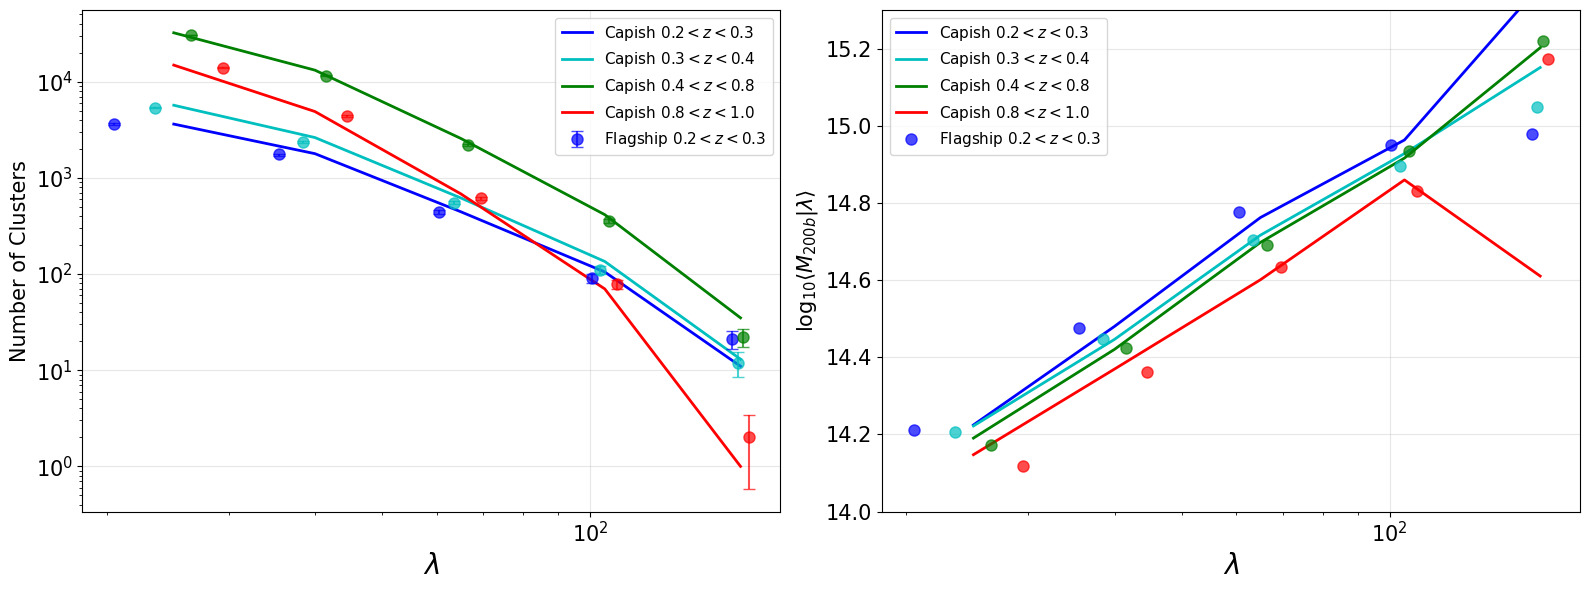


CAPISH vs FLAGSHIP COMPARISON

z-bin 1 (0.2-0.3):
  Flagship counts: [3643 1748  442   90   21]
  Capish counts:   [3619 1783  444  105   11]
  Flagship masses: [14.212, 14.476, 14.775, 14.951, 14.979]
  Capish masses:   [14.224, 14.48 , 14.762, 14.963, 15.364]

z-bin 2 (0.3-0.4):
  Flagship counts: [5346 2354  552  111   12]
  Capish counts:   [5681 2622  618  135   13]
  Flagship masses: [14.207, 14.448, 14.703, 14.896, 15.048]
  Capish masses:   [14.222, 14.446, 14.716, 14.928, 15.151]

z-bin 3 (0.4-0.8):
  Flagship counts: [30562 11562  2205   354    22]
  Capish counts:   [32190 13160  2569   414    35]
  Flagship masses: [14.173, 14.423, 14.692, 14.934, 15.22 ]
  Capish masses:   [14.19 , 14.42 , 14.698, 14.916, 15.202]

z-bin 4 (0.8-1.0):
  Flagship counts: [13934  4406   614    78     2]
  Capish counts:   [14851  4888   682    70     1]
  Flagship masses: [14.118, 14.361, 14.633, 14.83 , 15.172]
  Capish masses:   [14.147, 14.369, 14.601, 14.86 , 14.61 ]


In [11]:
# Plot: 1D comparison - counts and mean masses vs richness (similar to DES example)
fig = plt.figure(figsize=(16, 6))

# Colors and labels for redshift bins
colors = ['b-', 'c-', 'g-', 'r-']
z_labels = [f'$ {redshift_edges[i]:.1f} < z < {redshift_edges[i+1]:.1f} $' 
            for i in range(n_redshift_bins)]

# Subplot 1: Number of clusters
plt.subplot(121)

# Plot Capish predictions (solid lines) - transposed to iterate over redshift bins
for i in range(n_redshift_bins):
    plt.plot(richness_centers, capish_counts[:, i], colors[i], linewidth=2, 
             label=f'Capish {z_labels[i]}')

# Plot Flagship observations as points with Poisson errors
for i in range(n_redshift_bins):
    count_errors = np.sqrt(np.maximum(flagship_counts[:, i], 1))
    plt.errorbar(richness_centers + (i-1.5)*3, flagship_counts[:, i], yerr=count_errors,
                fmt='o', color=colors[i][0], markersize=8, capsize=4, alpha=0.7, 
                label=f'Flagship {z_labels[i]}' if i == 0 else None)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\lambda$', fontsize=20)
plt.ylabel('Number of Clusters', fontsize=15)
handles, labels = plt.gca().get_legend_handles_labels()
# Only show one Flagship entry in legend
new_labels = []
new_handles = []
for h, l in zip(handles, labels):
    if l not in new_labels:
        new_labels.append(l)
        new_handles.append(h)
plt.legend(new_handles, new_labels, loc='upper right', fontsize=11)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True, alpha=0.3)

# Subplot 2: Mean M200b
plt.subplot(122)

# Plot Capish predictions (solid lines)
for i in range(n_redshift_bins):
    plt.plot(richness_centers, capish_mean_masses[:, i], colors[i], linewidth=2, 
             label=f'Capish {z_labels[i]}')

# Plot Flagship observations as points (no error bars available for mean masses)
for i in range(n_redshift_bins):
    plt.plot(richness_centers + (i-1.5)*3, flagship_mean_masses[:, i], 
            'o', color=colors[i][0], markersize=8, alpha=0.7, 
            label=f'Flagship {z_labels[i]}' if i == 0 else None)

plt.xscale('log')
plt.ylim(14.0, 15.3)
plt.xlabel(r'$\lambda$', fontsize=20)
plt.ylabel(r'log$_{10} \langle M_{200b} | \lambda \rangle$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True, alpha=0.3)

handles, labels = plt.gca().get_legend_handles_labels()
new_labels = []
new_handles = []
for h, l in zip(handles, labels):
    if l not in new_labels:
        new_labels.append(l)
        new_handles.append(h)
plt.legend(new_handles, new_labels, loc='upper left', fontsize=11)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*60)
print("CAPISH vs FLAGSHIP COMPARISON")
print("="*60)
for i in range(n_redshift_bins):
    print(f"\nz-bin {i+1} ({redshift_edges[i]:.1f}-{redshift_edges[i+1]:.1f}):")
    print(f"  Flagship counts: {flagship_counts[:, i].astype(int)}")
    print(f"  Capish counts:   {capish_counts[:, i].astype(int)}")
    print(f"  Flagship masses: {np.array2string(flagship_mean_masses[:, i], precision=3, separator=', ')}")
    print(f"  Capish masses:   {np.array2string(capish_mean_masses[:, i], precision=3, separator=', ')}")

/scratch/users/c/cmurray/ipykernel_3153872/1558329659.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


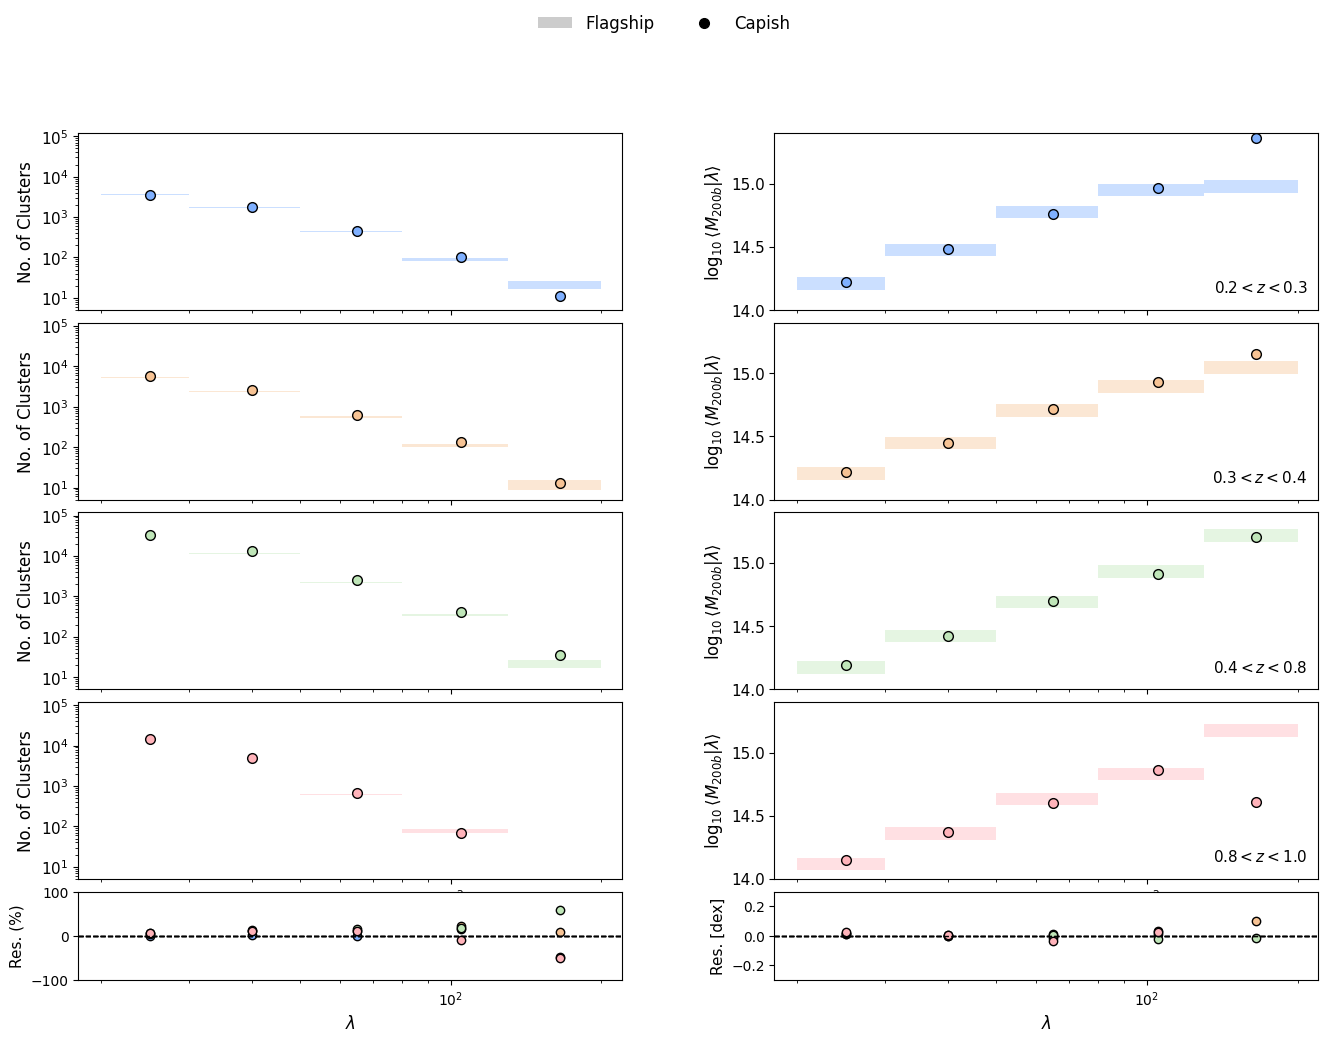

In [12]:
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Style choices
colors = ['#7fb0ff', '#f7c394', '#bfe6b8', '#ffb3ba']   # pastel colors for 4 redshift bins
point_edge = 'k'
z_labels = [f'${redshift_edges[i]:.1f} < z < {redshift_edges[i+1]:.1f}$' 
            for i in range(n_redshift_bins)]

fig = plt.figure(figsize=(16, 11))
gs = gridspec.GridSpec(5, 2, height_ratios=[1,1,1,1,0.5], hspace=0.08, wspace=0.28)

# --- top 4 rows: data bands (shaded) and Capish points ---
for i in range(n_redshift_bins):
    ax_counts = fig.add_subplot(gs[i, 0])
    ax_mass   = fig.add_subplot(gs[i, 1])
    
    # ---- COUNTS panel: shaded band = flagship_counts +/- sqrt(flagship_counts) (Poisson-like) ----
    count_errs = np.sqrt(np.maximum(flagship_counts[:, i], 1.0))
    for j in range(n_richness_bins):
        lam_l = richness_edges[j]
        lam_r = richness_edges[j+1]
        y_low  = max(1e-1, flagship_counts[j, i] - count_errs[j])
        y_high = flagship_counts[j, i] + count_errs[j]
        ax_counts.fill_between([lam_l, lam_r], [y_low, y_low], [y_high, y_high],
                               color=colors[i], alpha=0.4, edgecolor='none')

    ax_counts.plot(richness_centers, capish_counts[:, i], 'o',
                   markerfacecolor=colors[i], markeredgecolor=point_edge, markersize=7, zorder=10)

    ax_counts.set_xscale('log')
    ax_counts.set_yscale('log')
    ax_counts.set_xlim(18, 220)
    ax_counts.set_ylim(5e0, 1.2e5)
    ax_counts.set_ylabel('No. of Clusters', fontsize=12)
    ax_counts.tick_params(labelsize=11)
    if i < n_redshift_bins-1:
        ax_counts.set_xticklabels([])
    else:
        ax_counts.set_xlabel(r'$\lambda$', fontsize=13)

    # ---- MASS panel: shaded band ----
    for j in range(n_richness_bins):
        lam_l = richness_edges[j]
        lam_r = richness_edges[j+1]
        y_low  = flagship_mean_masses[j, i] - 0.05
        y_high = flagship_mean_masses[j, i] + 0.05
        ax_mass.fill_between([lam_l, lam_r], [y_low, y_low], [y_high, y_high],
                             color=colors[i], alpha=0.4, edgecolor='none')

    ax_mass.plot(richness_centers, capish_mean_masses[:, i], 'o',
                 markerfacecolor=colors[i], markeredgecolor=point_edge, markersize=7, zorder=10)

    ax_mass.set_xscale('log')
    ax_mass.set_xlim(18, 220)
    ax_mass.set_ylim(14.0, 15.4)
    ax_mass.set_ylabel(r'$\log_{10}\langle M_{200b}|\lambda\rangle$', fontsize=12)
    ax_mass.tick_params(labelsize=11)
    if i < n_redshift_bins-1:
        ax_mass.set_xticklabels([])
    else:
        ax_mass.set_xlabel(r'$\lambda$', fontsize=13)

    ax_mass.text(0.98, 0.08, z_labels[i], transform=ax_mass.transAxes,
                 ha='right', va='bottom', fontsize=11,
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=6))

# --- bottom row: residuals ---
ax_res_counts = fig.add_subplot(gs[n_redshift_bins, 0])
ax_res_mass   = fig.add_subplot(gs[n_redshift_bins, 1])

for i in range(n_redshift_bins):
    with np.errstate(divide='ignore', invalid='ignore'):
        res_counts = (capish_counts[:, i] - flagship_counts[:, i]) / flagship_counts[:, i] * 100.0
        res_counts = np.where(flagship_counts[:, i] > 0, res_counts, np.nan)
        res_masses = capish_mean_masses[:, i] - flagship_mean_masses[:, i]

    ax_res_counts.plot(richness_centers, res_counts, 'o', color=colors[i], 
                      markeredgecolor=point_edge, markersize=6)
    ax_res_counts.axhline(0.0, linestyle='--', color='k', linewidth=1)

    ax_res_mass.plot(richness_centers, res_masses, 'o', color=colors[i], 
                    markeredgecolor=point_edge, markersize=6)
    ax_res_mass.axhline(0.0, linestyle='--', color='k', linewidth=1)

ax_res_counts.set_xscale('log')
ax_res_counts.set_xlim(18, 220)
ax_res_counts.set_xlabel(r'$\lambda$', fontsize=12)
ax_res_counts.set_ylabel('Res. (%)', fontsize=11)
ax_res_counts.tick_params(labelsize=10)
ax_res_counts.set_ylim(-100, 100)

ax_res_mass.set_xscale('log')
ax_res_mass.set_xlim(18, 220)
ax_res_mass.set_xlabel(r'$\lambda$', fontsize=12)
ax_res_mass.set_ylabel('Res. [dex]', fontsize=11)
ax_res_mass.tick_params(labelsize=10)
ax_res_mass.set_ylim(-0.3, 0.3)

legend_handles = [
    Patch(facecolor='gray', alpha=0.4, label='Flagship'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='k',
           markeredgecolor=point_edge, markersize=7, label='Capish')
]
fig.legend(handles=legend_handles, loc='upper center', ncol=2, frameon=False, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 5. Parameter Inference

Use simulation-based inference (SBI) to infer cosmological and mass-observable parameters from Flagship data.

In [13]:
# Check if sbi is available, install if needed
try:
    import sbi
    print(f"sbi version: {sbi.__version__}")
except ImportError:
    print("sbi not found. Install with: pip install sbi")
    print("For now, we'll show the inference workflow structure.")

sbi version: 0.25.0


In [14]:
# Define parameter priors for inference
# We'll infer a subset of parameters, keeping others fixed

# Parameters to infer (examples):
# - Omega_m: matter density
# - sigma8: amplitude of matter fluctuations  
# - alpha_lambda, beta_lambda: mass-richness relation parameters

import torch
from sbi.utils import BoxUniform

# Define priors (adjust ranges as needed)
prior_dict = {
    'Omega_m': [0.2, 0.4],      # Reasonable range for matter density
    'sigma8': [0.7, 0.9],        # Amplitude of fluctuations
    'alpha_lambda': [-10.0, -8.5],  # MR relation normalization
    'beta_lambda': [0.6, 0.9],      # MR relation slope
}

# Create prior distribution
prior_min = torch.tensor([bounds[0] for bounds in prior_dict.values()])
prior_max = torch.tensor([bounds[1] for bounds in prior_dict.values()])
prior = BoxUniform(low=prior_min, high=prior_max)

print("Prior ranges:")
for param, bounds in prior_dict.items():
    print(f"  {param}: [{bounds[0]}, {bounds[1]}]")

print(f"\nNumber of parameters to infer: {len(prior_dict)}")

Prior ranges:
  Omega_m: [0.2, 0.4]
  sigma8: [0.7, 0.9]
  alpha_lambda: [-10.0, -8.5]
  beta_lambda: [0.6, 0.9]

Number of parameters to infer: 4


/sps/euclid/Users/cmurray/miniconda3/envs/capish/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# Create simulator wrapper for SBI
# SBI expects: simulator(parameters) -> observations

def sbi_simulator(theta_tensor):
    """
    Wrapper for UniverseSimulator compatible with SBI.
    
    Args:
        theta_tensor: torch.Tensor of shape (n_params,) with values:
                     [Omega_m, sigma8, alpha_lambda, beta_lambda]
    
    Returns:
        torch.Tensor: Flattened summary statistics (counts + masses)
    """
    # Convert to numpy and construct full parameter vector
    theta_np = theta_tensor.cpu().numpy()
    
    # Full parameter vector for simulator (keep gamma_lambda, M_min fixed)
    full_params = [
        float(theta_np[0]),  # Omega_m (varying)
        float(theta_np[1]),  # sigma8 (varying)
        float(theta_np[2]),  # alpha_lambda (varying)
        float(theta_np[3]),  # beta_lambda (varying)
        0.0,                 # gamma_lambda (fixed)
        float(MASS_RICHNESS_PARAMS['M_min'])  # M_min (fixed)
    ]
    
    # Run simulation
    summary_stats = simulator.run_simulation(full_params)
    
    # Flatten tuple (counts, masses) -> single vector
    counts, masses = summary_stats
    data_vector = np.concatenate([counts.flatten(), masses.flatten()])
    
    return torch.tensor(data_vector, dtype=torch.float32)

print("SBI simulator wrapper created")
print(f"Expected output dimension: {2 * n_richness_bins * n_redshift_bins} (counts + masses)")

SBI simulator wrapper created
Expected output dimension: 40 (counts + masses)


In [16]:
# Prepare observed data (Flagship) for inference
observed_counts = flagship_counts.flatten()
observed_masses = flagship_mean_masses.flatten()
observed_data = np.concatenate([observed_counts, observed_masses])
observed_data_tensor = torch.tensor(observed_data, dtype=torch.float32)

print(f"Observed data vector shape: {observed_data.shape}")
print(f"Number of summary statistics: {len(observed_data)}")
print(f"  - Count bins: {len(observed_counts)}")
print(f"  - Mass bins: {len(observed_masses)}")

Observed data vector shape: (40,)
Number of summary statistics: 40
  - Count bins: 20
  - Mass bins: 20


In [17]:
# Train neural posterior estimator (NPE)
# This requires running many simulations - computationally expensive!

from sbi.inference import SNPE

# Number of simulations for training
num_simulations = 10000  # Increase for better results (e.g., 50k-100k)

print(f"Setting up inference with {num_simulations} simulations")
print("Note: This will take significant time to run!")
print("\nInference workflow:")
print("1. Sample parameters from prior")
print("2. Run simulations for each parameter set")
print("3. Train neural network to estimate posterior")
print("4. Sample from posterior given observed data")

# Initialize inference
inference = SNPE(prior=prior)

print("\nReady to run inference (not executing in this notebook for time reasons)")
print("To run inference:")
print("  theta = prior.sample((num_simulations,))")
print("  x = [sbi_simulator(t) for t in theta]")
print("  inference.append_simulations(theta, torch.stack(x))")
print("  posterior = inference.train()")
print("  samples = posterior.sample((10000,), x=observed_data_tensor)")

Setting up inference with 10000 simulations
Note: This will take significant time to run!

Inference workflow:
1. Sample parameters from prior
2. Run simulations for each parameter set
3. Train neural network to estimate posterior
4. Sample from posterior given observed data

Ready to run inference (not executing in this notebook for time reasons)
To run inference:
  theta = prior.sample((num_simulations,))
  x = [sbi_simulator(t) for t in theta]
  inference.append_simulations(theta, torch.stack(x))
  posterior = inference.train()
  samples = posterior.sample((10000,), x=observed_data_tensor)


### Inference Results (Placeholder)

Once inference is complete, you would:

1. **Sample from posterior**: Draw parameter samples given the Flagship data
2. **Analyze posteriors**: Plot 1D and 2D marginal distributions
3. **Compare to truth**: Check if true Flagship parameters are recovered
4. **Posterior predictive checks**: Generate predictions from posterior samples and compare to data

Example posterior analysis code:

```python
# Sample from posterior
samples = posterior.sample((10000,), x=observed_data_tensor)

# Plot corner plot
import corner
fig = corner.corner(
    samples.numpy(),
    labels=['$\Omega_m$', '$\sigma_8$', r'$\alpha_\lambda$', r'$\beta_\lambda$'],
    truths=[0.319, 0.8, -9.348, 0.75],  # True values
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True
)
plt.show()

# Compute summary statistics
for i, param in enumerate(prior_dict.keys()):
    median = samples[:, i].median()
    std = samples[:, i].std()
    print(f"{param}: {median:.3f} ± {std:.3f}")
```